In [1]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import shutil
from pathlib import Path

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Loading packages

In [3]:
import sys
from pathlib import Path

here_path = Path().resolve()
repo_path = here_path.parents[1]
sys.path.append(str(repo_path))

In [4]:
from py.utils import verifyDir, verifyFile, verifyType

In [5]:
from py.config import Config

cfg = Config()

np.random.seed(cfg.RANDOM_STATE)
cfg.DATA_PATH, cfg.MODEL_PATH

('/media/felipe/DATA19/datasets/', '/media/felipe/DATA19/models/')

In [6]:
QSCORE_PATH=f"{cfg.DATA_PATH}pp1/Qscores/"
IMAGES_PATH = f"{cfg.DATA_PATH}pp1/images/"

### Loading data

In [7]:
from py.datasets import PlacePulse

pp = PlacePulse()

In [8]:
metrics = ["safety", "uniquely", "wealthy"]

In [9]:
data_df = pd.read_csv(f"{QSCORE_PATH}scores_raw.csv")
data_df.rename(columns={
                    'ID': 'image_id',
                    'QS_Upperclass': 'wealthy', 
                    'Error_QS_Upperclass': 'wealthy_err', 
                    'QS_Unique': 'uniquely', 
                    'Error_QS_Unique': 'uniquely_err', 
                    'QS_Safer': 'safety', 
                    'Error_QS_Safer': 'safety_err', 
                    'City': 'city',
                    'Lat': 'lat', 
                    "Lon":"long",
                    'File_Location': 'image_path',
                    }, 
               inplace=True)
data_df["city"] = data_df["city"].replace('New York City', 'New York')
data_df[['continent', 'country', 'city']] = data_df.apply( lambda row: pp.localize_point(row['lat'], row['long']), axis=1, result_type='expand')
data_df[metrics] = data_df[metrics].fillna(0.0)
data_df["image_path"] = data_df.apply(lambda row: f'{row["city"]}/{row["image_id"]}.jpg', axis=1)

### Mapping same locations

In [10]:
def verify_image_path(img_list):
    have_nan=0
    for img in img_list:
        if pd.isna(img):
            have_nan+=1
            
    return have_nan

In [11]:
location_df = data_df[["image_id", "lat", "long", "city", "country", "continent", "image_path"]].copy()
location_df.rename(columns={"image_id": "location_id"}, inplace=True)

In [12]:
repetitions_df = pd.pivot_table(location_df,
                      index=["lat", "long", "city", "country", "continent"],
                      values=["location_id", "image_path"],
                      aggfunc={
                          "location_id": list,
                          "image_path":list
                      }).reset_index()
repetitions_df["num_locations"] = repetitions_df["location_id"].apply(lambda x: len(x))
repetitions_df["image_id"] = repetitions_df["location_id"].apply(lambda x: x[0])

repetitions_df.sort_values(by=["num_locations"], inplace=True, ascending=False)
repetitions_df=repetitions_df[["image_id"] + repetitions_df.columns[:-1].to_list()].copy()
repetitions_df

,image_id,lat,long,city,country,continent,image_path,location_id,num_locations
1751,4939,47.80583,13.05317,Salzburg,Austria,Europe,"[Salzburg/4939.jpg, Salzburg/4938.jpg, Salzbur...","[4939, 4938, 4936, 4937, 3180, 3181]",6
1609,3080,47.79567,13.06483,Salzburg,Austria,Europe,"[Salzburg/3080.jpg, Salzburg/3082.jpg, Salzbur...","[3080, 3082, 3077, 3081, 3078, 3079]",6
1780,3108,47.80783,13.04300,Salzburg,Austria,Europe,"[Salzburg/3108.jpg, Salzburg/3109.jpg, Salzbur...","[3108, 3109, 3107, 3112, 3111, 3110]",6
1802,3232,47.80917,13.04833,Salzburg,Austria,Europe,"[Salzburg/3232.jpg, Salzburg/3233.jpg, Salzbur...","[3232, 3233, 3231, 3236, 3234, 3235]",6
1964,3440,47.82283,13.04917,Salzburg,Austria,Europe,"[Salzburg/3440.jpg, Salzburg/3441.jpg, Salzbur...","[3440, 3441, 3444, 3443, 3439]",5
...,...,...,...,...,...,...,...,...,...
1607,3017,47.79567,13.01883,Salzburg,Austria,Europe,[Salzburg/3017.jpg],[3017],1
1606,3018,47.79533,13.01933,Salzburg,Austria,Europe,[Salzburg/3018.jpg],[3018],1
1605,2949,47.79517,13.07567,Salzburg,Austria,Europe,[Salzburg/2949.jpg],[2949],1
1604,3086,47.79517,13.05900,Salzburg,Austria,Europe,[Salzburg/3086.jpg],[3086],1


In [13]:
repetitions_df.to_csv(f"{cfg.DATA_PATH}pp1/repeated_locations.csv", sep=";", index=False)

In [14]:
repetitions_df["num_image_nan"] = repetitions_df["image_path"].apply(lambda x: verify_image_path(x))

In [15]:
repetitions_df[(repetitions_df["num_locations"]!=repetitions_df["num_image_nan"]) & (repetitions_df["num_image_nan"]!=0)]

,image_id,lat,long,city,country,continent,image_path,location_id,num_locations,num_image_nan


In [16]:
repetitions_df[(repetitions_df["num_image_nan"]==1)]

,image_id,lat,long,city,country,continent,image_path,location_id,num_locations,num_image_nan


#### Identify images with repeated locations

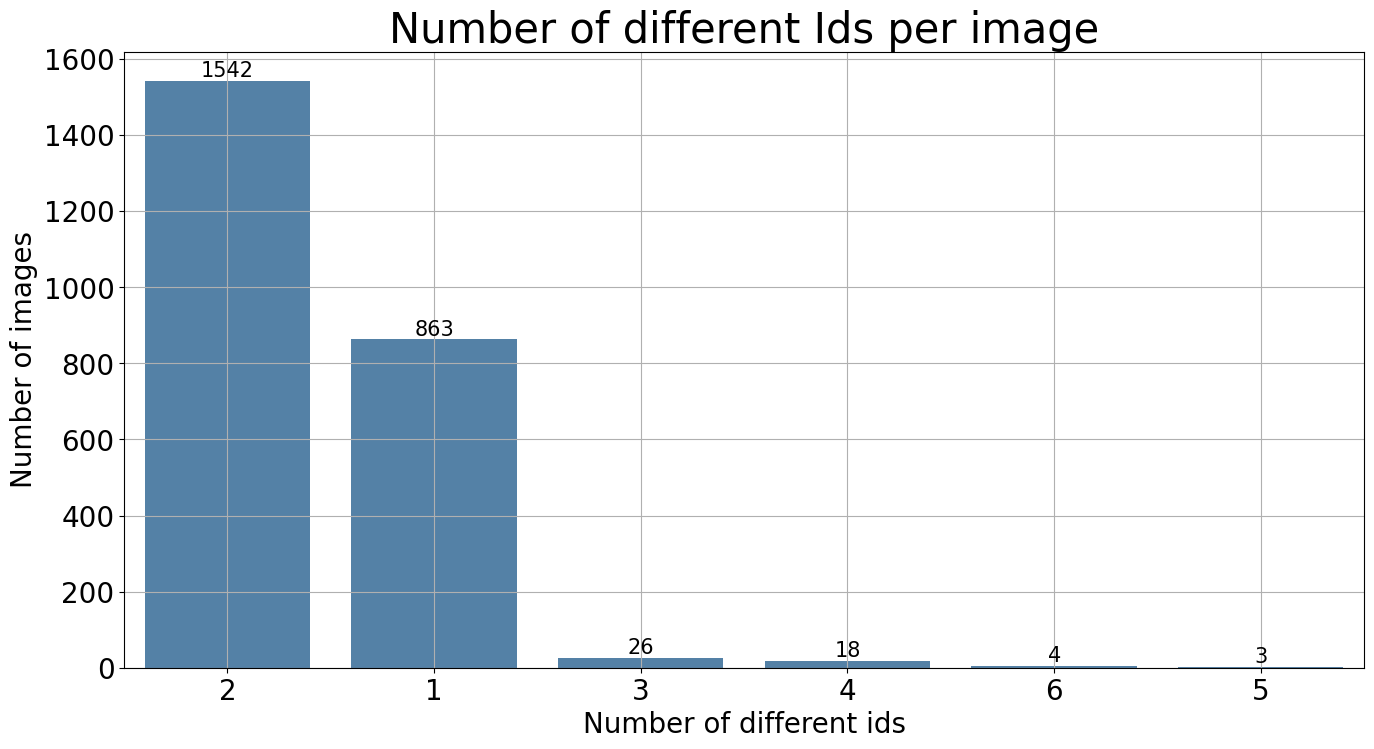

In [17]:
fig, ax = plt.subplots(figsize=(16,8), nrows=1, ncols=1, sharex=False, sharey=False)

estado_df = repetitions_df["num_locations"].value_counts().reset_index()

sns_fig = sns.barplot(
            data=estado_df,
            x=estado_df.columns[0],
            y=estado_df.columns[1],
            ax=ax,
            color="steelblue",
            order=estado_df.sort_values(estado_df.columns[1], ascending=False)[estado_df.columns[0]]
           )

sns_fig.set_title(f"Number of different Ids per image", fontsize=30)
sns_fig.set_ylabel(f"Number of images", fontsize=20)
sns_fig.set_xlabel('Number of different ids', fontsize=20)

# rotate the axis ticklabels
_ = sns_fig.tick_params(axis='x', rotation=0, labelsize=20)

# rotate the axis ticklabels
_ = sns_fig.tick_params(axis='y', labelsize=20)

# add annotation
_ = sns_fig.bar_label(sns_fig.containers[0], fmt='%0.0f', fontsize=15,rotation=0)

# add a space on y for the annotations
#sns_fig.margins(x=0.1)
ax.grid(True)

# fig.savefig(f'{PROCESSED_IMAGES_PATH}/repeated_images_by_locations.png')
plt.show()

#### Number of images with more than 1 different ID per city

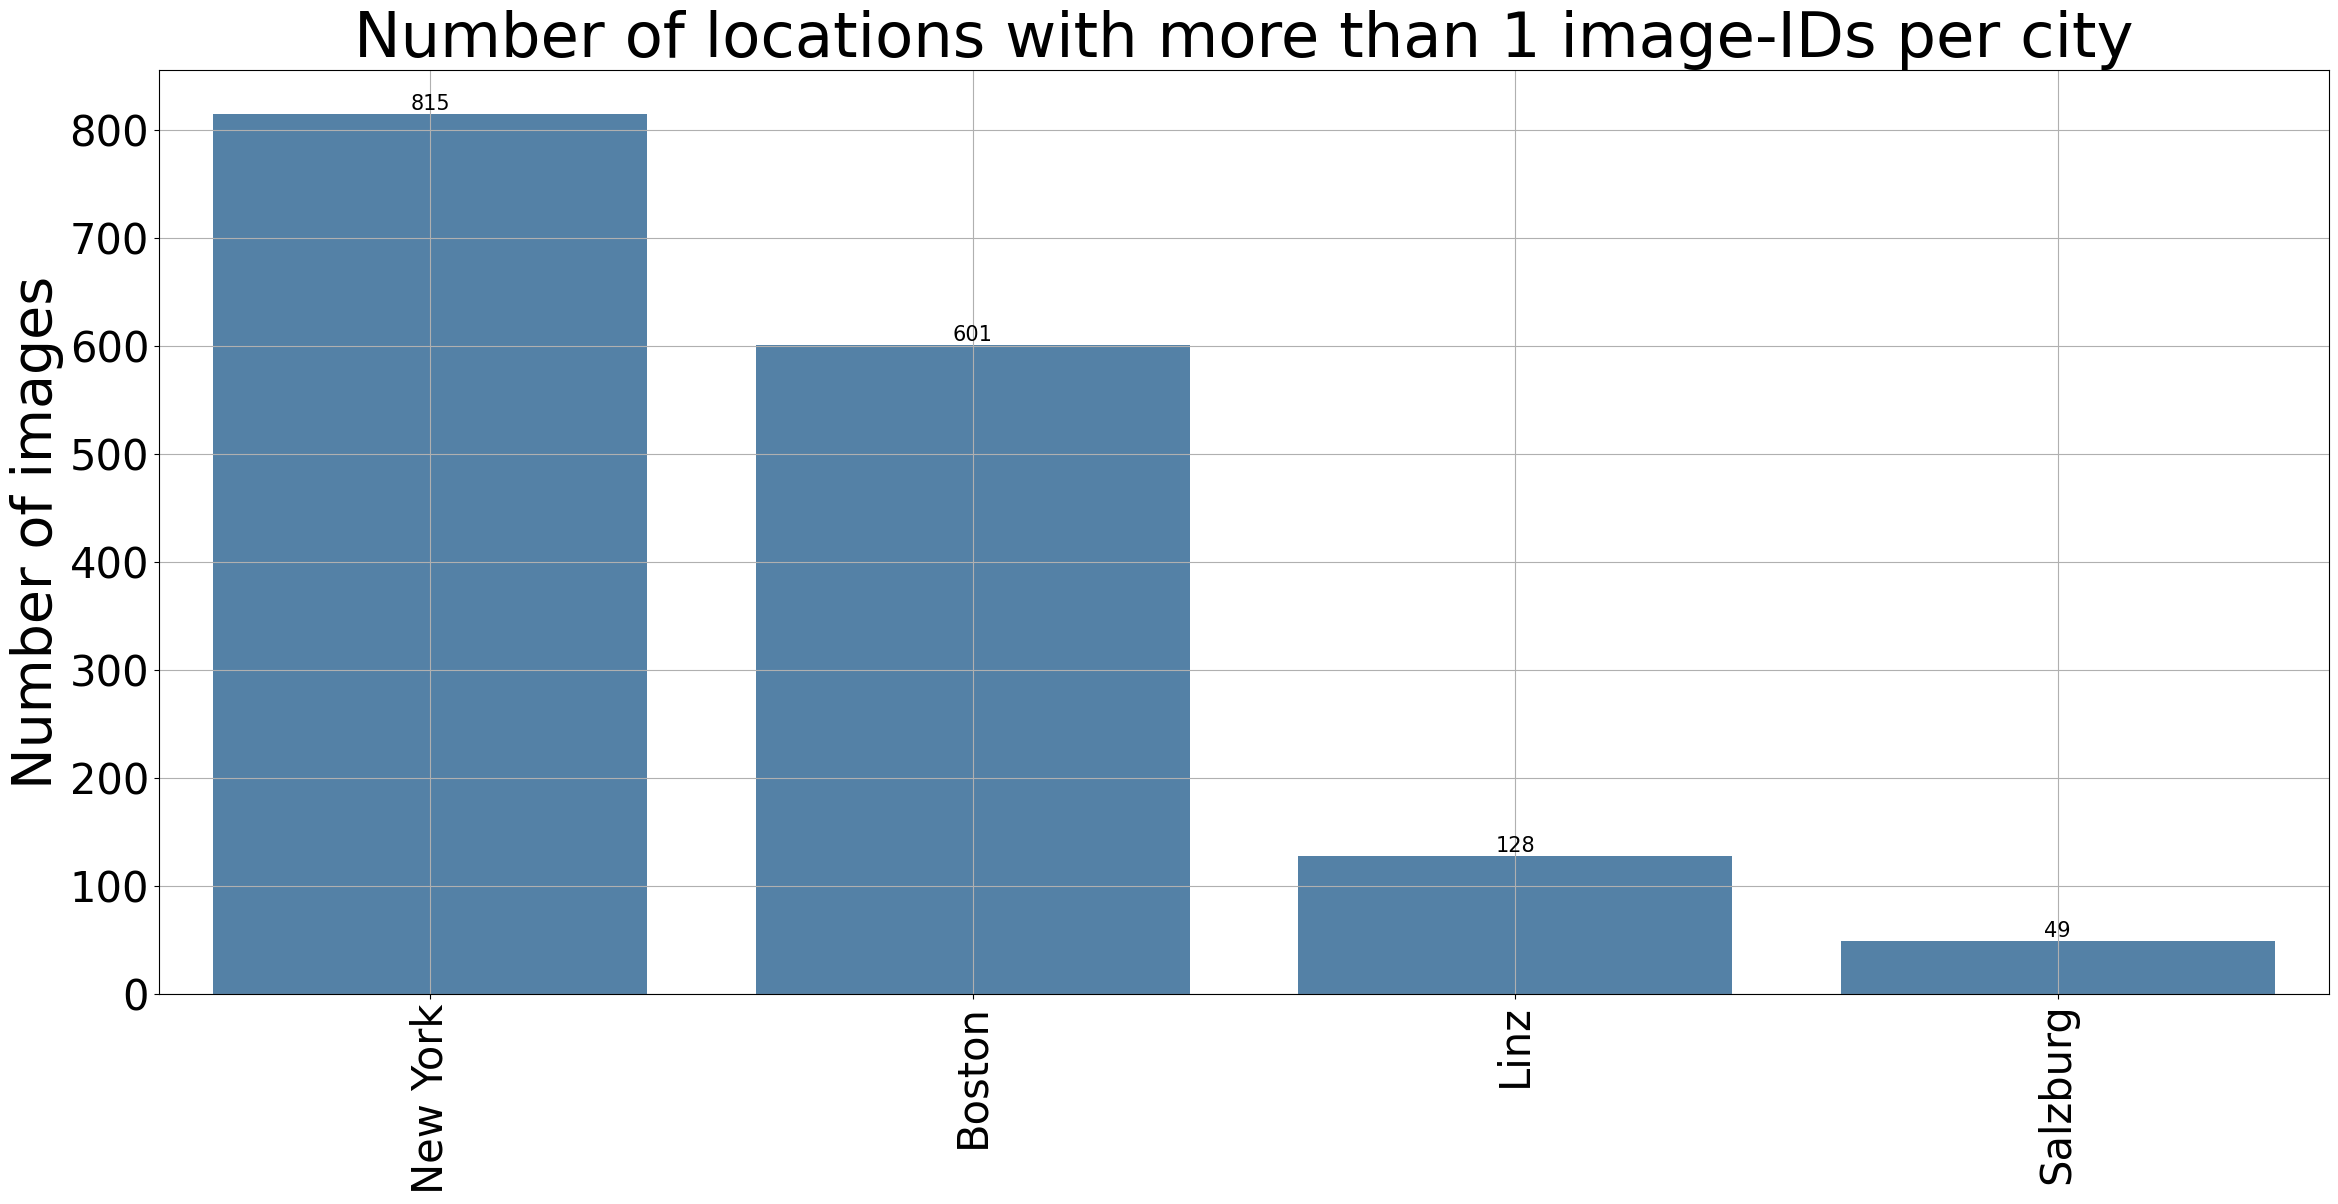

In [18]:
fig, ax = plt.subplots(figsize=(28,12), nrows=1, ncols=1, sharex=False, sharey=False)

estado_df = repetitions_df[repetitions_df["num_locations"] >1]["city"].value_counts().reset_index()

sns_fig = sns.barplot(
            data=estado_df,
            x=estado_df.columns[0],
            y=estado_df.columns[1],
            ax=ax,
            color="steelblue",
            #order=estado_df.sort_values(estado_df.columns[1], ascending=False)[estado_df.columns[0]]
           )

sns_fig.set_title(f"Number of locations with more than 1 image-IDs per city", fontsize=45)
sns_fig.set_ylabel(f"Number of images", fontsize=40)
sns_fig.set_xlabel('', fontsize=20)

# rotate the axis ticklabels
_ = sns_fig.tick_params(axis='x', rotation=90, labelsize=30)

# rotate the axis ticklabels
_ = sns_fig.tick_params(axis='y', labelsize=30)

# add annotation
_ = sns_fig.bar_label(sns_fig.containers[0], fmt='%0.0f', fontsize=15,rotation=0)

# add a space on y for the annotations
#sns_fig.margins(x=0.1)
ax.grid(True)

# fig.savefig(f'{PROCESSED_IMAGES_PATH}/number_images_with_different_id_per_city.png')
plt.show()

#### Mapping and deleting repetitions

In [19]:
locations_dict = {}
for same_values in repetitions_df[repetitions_df["num_locations"]>1]["location_id"].values:
    k = same_values[0]
    values = same_values[1:]
    for v in values:
        if v not in locations_dict:
            locations_dict[v] = k

In [20]:
data_df = data_df[ data_df["image_id"].isin( repetitions_df["image_id"].unique().tolist() ) ].copy()
data_df

,image_id,safety,safety_err,uniquely,uniquely_err,wealthy,wealthy_err,lat,long,city,Heading,Pitch,image_path,continent,country
0,1867,4.312082,0.528429,3.388842,0.231139,4.307236,0.472743,48.27100,14.30900,Linz,NaN,NaN,Linz/1867.jpg,Europe,Austria
1,4447,7.424497,0.508995,8.577250,0.683006,6.497493,0.609597,42.38090,-71.06650,Boston,340.0,8.0,Boston/4447.jpg,North America,USA
2,4026,4.960523,0.578983,3.792243,0.796483,5.437212,0.606079,40.82590,-73.92490,New York,7.0,5.0,New York/4026.jpg,North America,USA
3,4027,6.941864,0.407260,6.660700,0.738466,5.872327,0.609209,40.78750,-73.95280,New York,335.0,10.0,New York/4027.jpg,North America,USA
4,4024,6.359094,0.575126,6.288706,0.704695,6.474079,0.596200,40.77280,-73.95840,New York,356.0,12.0,New York/4024.jpg,North America,USA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4113,1715,3.773390,0.447843,4.645925,0.766897,3.396290,0.468702,48.27300,14.27350,Linz,NaN,NaN,Linz/1715.jpg,Europe,Austria
4126,3194,3.883935,0.359039,5.370955,0.741104,3.579800,0.347731,47.80817,13.06050,Salzburg,NaN,NaN,Salzburg/3194.jpg,Europe,Austria
4129,3191,3.181993,0.308140,3.719056,0.617220,3.849015,0.421877,47.80650,13.05633,Salzburg,NaN,NaN,Salzburg/3191.jpg,Europe,Austria
4130,3190,3.883923,0.427387,6.164288,0.861303,5.069103,0.535396,47.80633,13.05600,Salzburg,NaN,NaN,Salzburg/3190.jpg,Europe,Austria


In [21]:
data_df.to_csv(f"{QSCORE_PATH}scores.csv", sep=";", index=False)

### Aggregate statistics

In [22]:
cities = data_df["city"].unique().tolist()

In [23]:
agg_stats = {"city": cities,}

for metric in metrics:
    mean_metric_ = []
    std_metric_ = []
    num_images_ = []
    continent = []
    country = []
    for city in cities:
      city_df = data_df[data_df["city"]==city].copy()
      num_images_.append(len(city_df))
      mean_metric_.append(city_df[metric].mean())
      std_metric_.append(city_df[metric].std())
      country.append(city_df["country"].unique()[0])
      continent.append(city_df["continent"].unique()[0])
    agg_stats["country"] = country
    agg_stats["continent"] = continent
    agg_stats["num_images"] = num_images_
    agg_stats[metric+"_mean"] = mean_metric_
    agg_stats[metric+"_std"] = std_metric_

agg_stats_df = pd.DataFrame(agg_stats, columns=list(agg_stats.keys()))
agg_stats_df

,city,country,continent,num_images,safety_mean,safety_std,uniquely_mean,uniquely_std,wealthy_mean,wealthy_std
0,Linz,Austria,Europe,468,4.884665,0.765988,4.830309,0.944035,5.040145,0.941304
1,Boston,USA,North America,635,4.968416,1.506091,4.771246,1.261479,5.003456,1.650288
2,New York,USA,North America,889,4.481787,1.410656,4.436405,1.246248,4.311322,1.502219
3,Salzburg,Austria,Europe,464,4.780857,0.850606,5.009481,0.968426,4.910999,0.954988


In [24]:
agg_stats_df.to_csv(f"{QSCORE_PATH}aggregate_statistics.csv", index=False)

### Renaming images

In [25]:
years = ["2011", "2013", "2019"]

In [33]:
import re

pattern = re.compile(r"^id_(\d+)_\d+_\d+\.jpg$", re.IGNORECASE)

In [48]:
for dirpath, dirnames, filenames in os.walk(IMAGES_PATH):
    for fname in filenames:
        m = pattern.match(fname)
        if not m:
            continue

        image_id = m.group(1)
        new_name = f"{image_id}.jpg"

        old_path = os.path.join(dirpath, fname)
        new_path = os.path.join(dirpath, new_name)

        if "New York City" in new_path:
            new_path = new_path.replace("New York City", "New York")
            verifyDir( "/".join( new_path.split("/")[:-1] ) )
        
        if old_path == new_path:
            continue

        # Avoid overwriting if multiple resolutions exist
        if verifyFile(new_path):
            print(f"SKIP (exists): {new_path}  <- {old_path}")
            continue

        os.rename(old_path, new_path)
        #print(f"OK: {old_path} -> {new_path}")